In [63]:
import pandas as pd
import matplotlib.pyplot as plt
# Set matplotlib backend to plotly
pd.options.plotting.backend = "plotly"

In [64]:
df_1hour = pd.read_csv('../../Data/1hour_concat.csv', sep=',')
# Convertir les dates de type string en type datetime
df_1hour['Date'] = pd.to_datetime(df_1hour['Date'])

df_pc = df_1hour
df_pc = df_pc.sort_values(by=['Date', 'Canton'])
df_pc = df_pc.reset_index(drop=True)
# Multiply consumption by -1 to get a negative value
df_pc['Consumption'] = df_pc['Consumption'] * -1

# Remove the rows with a production or consumption value of 0
df_pc = df_pc[df_pc.Production != 0]
df_pc = df_pc[df_pc.Consumption != 0]
# reindex the dataframe
df_pc = df_pc.reset_index(drop=True)
# Calculer les totaux de production et de consommation par date
totals = df_pc.groupby('Date').agg(
    {'Production': 'sum', 'Consumption': 'sum'}).reset_index()
totals['Canton'] = 'CH'
totals = totals[['Date', 'Production', 'Consumption', 'Canton']]

In [65]:
prod = totals[['Date', 'Production']]
cons = totals[['Date', 'Consumption']]
cons['Consumption'] = cons['Consumption'] * -1

C:\Users\thozi\AppData\Local\Temp\ipykernel_22028\3400457334.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
dates = pd.DataFrame(pd.date_range(start='2023-03-13', end='2060-01-01', freq='D'), columns=['Date'])

# Add the dates to the prod and cons dataframes
prod_full = pd.concat([prod, dates], ignore_index=True)
cons_full = pd.concat([cons, dates], ignore_index=True)


prod = prod.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')
cons = cons.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

prod_full = prod_full.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')
cons_full = cons_full.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

prod_pred = prod_full[prod_full['Date'] >= '2023-03-13']
cons_pred = cons_full[cons_full['Date'] >= '2023-03-13']

print(prod.shape)
print(prod_full.shape)
print(prod_pred.shape)

cons[:-1].tail(50)

(427, 2)
(2349, 2)
(1922, 2)


,Date,Consumption
376,2022-03-21,1.234031e+09
377,2022-03-28,1.189796e+09
378,2022-04-04,1.231370e+09
379,2022-04-11,1.232638e+09
380,2022-04-18,1.077118e+09
381,2022-04-25,1.109388e+09
382,2022-05-02,1.129495e+09
383,2022-05-09,1.092783e+09
384,2022-05-16,1.103423e+09
385,2022-05-23,1.092916e+09


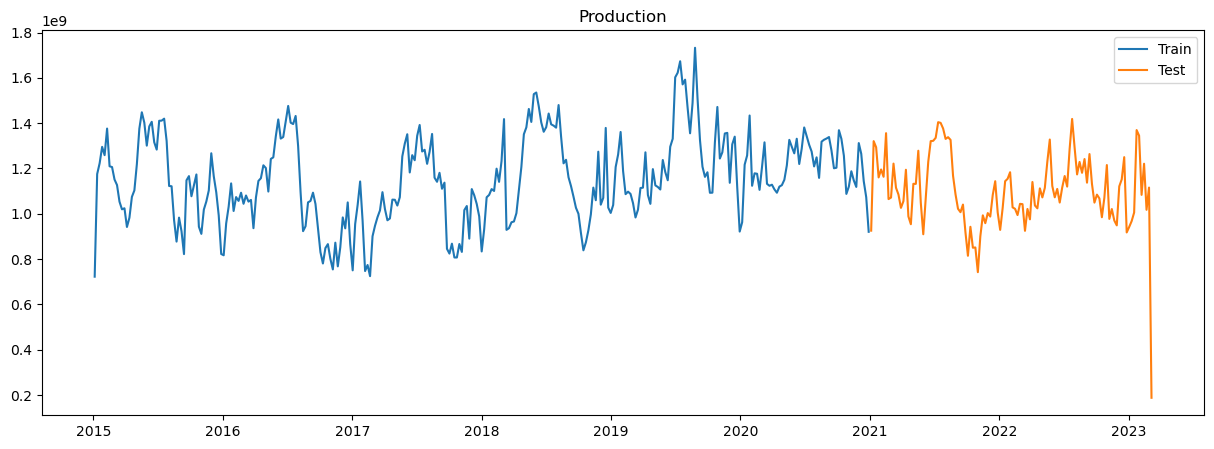

In [67]:
#Separate the dataframes in two sets, one for training and one for testing
prod_train = prod[prod['Date'] < '2021-01-01']
prod_test = prod[prod['Date'] >= '2021-01-01']
cons_train = cons[cons['Date'] < '2021-01-01']
cons_test = cons[cons['Date'] >= '2021-01-01']

# Plot the train and test sets
plt.figure(figsize=(15, 5))
plt.plot(prod_train['Date'], prod_train['Production'], label='Train')
plt.plot(prod_test['Date'], prod_test['Production'], label='Test')
plt.legend(loc='best')
plt.title('Production')
plt.show()

Test MSE: 32972664975756664.000


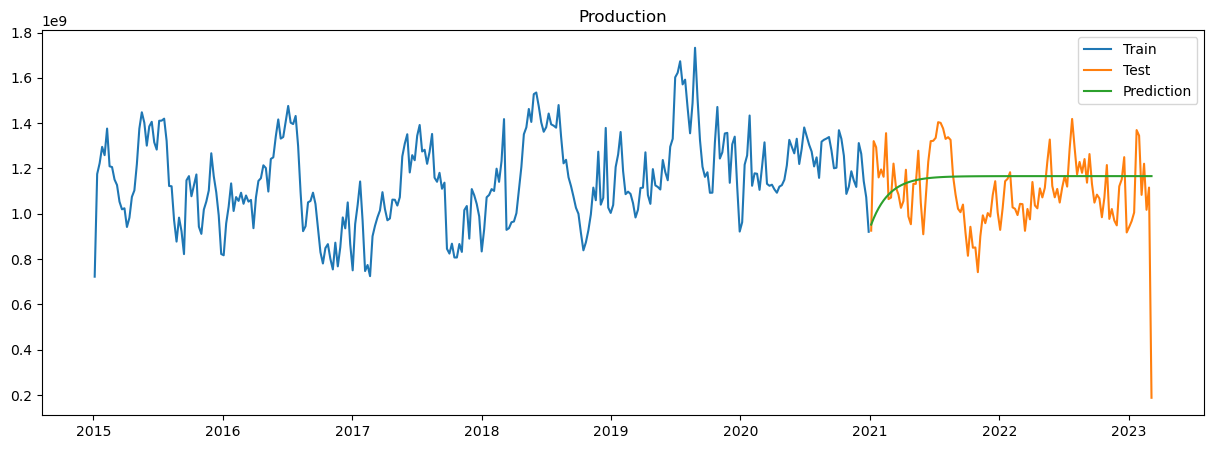

In [68]:
#Using those 2 sets, we weill train an ARIMA model to predict the production
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Fit the model
model = ARIMA(prod_train['Production'], order=(1, 1, 1))
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(prod_train), end=len(prod_train)+len(prod_test)-1, dynamic=False)

# Calculate the error
error = mean_squared_error(prod_test['Production'], predictions)
print('Test MSE: %.3f' % error)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(prod_train['Date'], prod_train['Production'], label='Train')
plt.plot(prod_test['Date'], prod_test['Production'], label='Test')
plt.plot(prod_test['Date'], predictions, label='Prediction')
plt.legend(loc='best')
plt.title('Production')
plt.show()


Test MSE: 25351377574617744.000


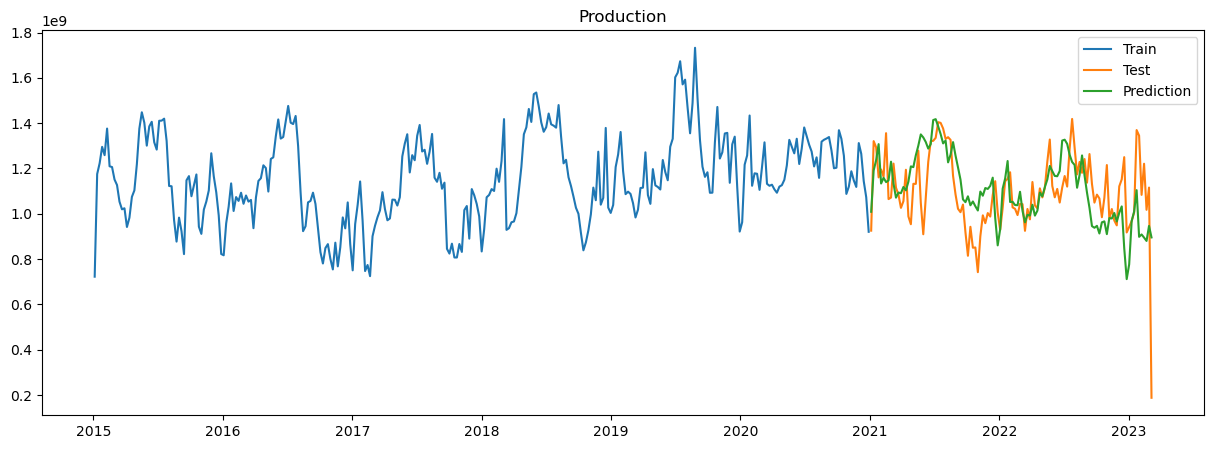

In [69]:
#Using those 2 sets, we weill train a SARIMAX model to predict the production
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np


model = SARIMAX(prod_train['Production'], order=(2, 2, 2), seasonal_order=(2, 1, 1, 52))
model_fit = model.fit()
predictions = model_fit.predict(start=len(prod_train), end=len(prod_train)+len(prod_test)-1, dynamic=False)
error = mean_squared_error(prod_test['Production'], predictions)
print('Test MSE: %.3f' % error)



# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(prod_train['Date'], prod_train['Production'], label='Train')
plt.plot(prod_test['Date'], prod_test['Production'], label='Test')
plt.plot(prod_test['Date'], predictions, label='Prediction')
plt.legend(loc='best')
plt.title('Production')
plt.show()

c:\Users\thozi\miniconda3\envs\PI\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Test MSE: 13435715186014998.000


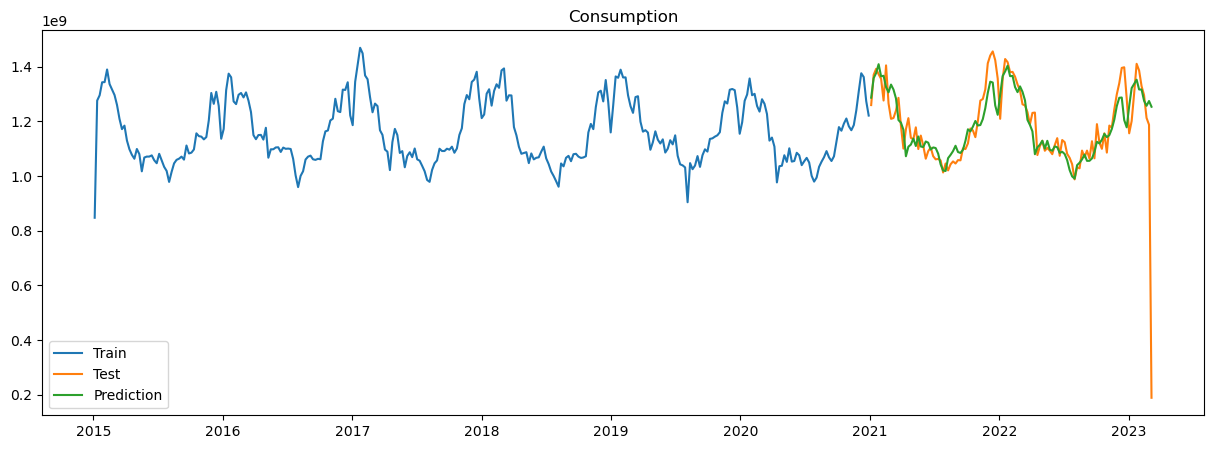

In [70]:
model = SARIMAX(cons_train['Consumption'], order=(2, 2, 2), seasonal_order=(2, 1, 1, 52))
model_fit = model.fit()
predictions = model_fit.predict(start=len(cons_train), end=len(cons_train)+len(cons_test)-1, dynamic=False)
error = mean_squared_error(cons_test['Consumption'], predictions)
print('Test MSE: %.3f' % error)



# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(cons_train['Date'], cons_train['Consumption'], label='Train')
plt.plot(cons_test['Date'], cons_test['Consumption'], label='Test')
plt.plot(cons_test['Date'], predictions, label='Prediction')
plt.legend(loc='best')
plt.title('Consumption')
plt.show()

Weekly: p=2 d=2 q=2 P=2 D=1 Q=1, MSE=25351377574617744.000

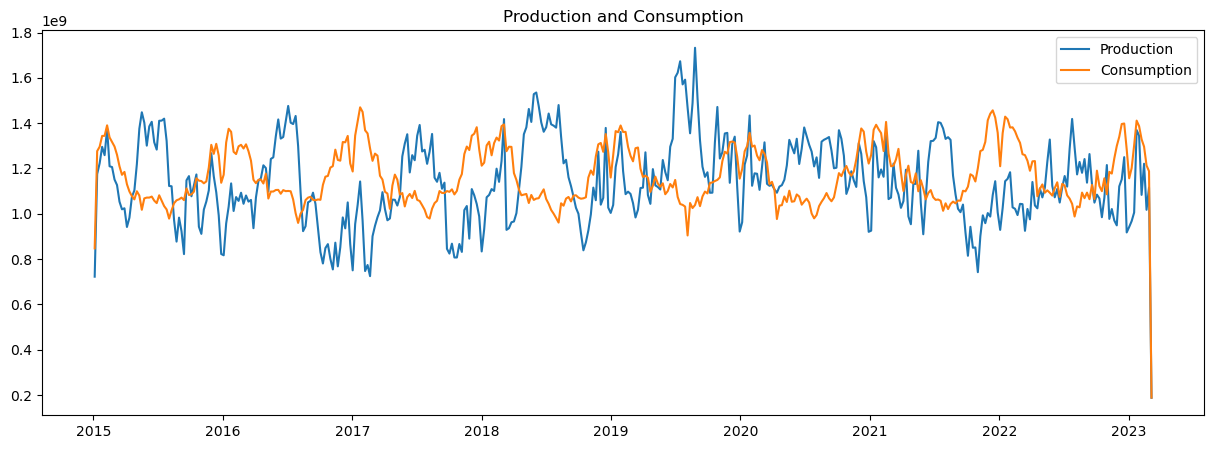

(1922, 2)


In [71]:
# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(prod['Date'], prod['Production'], label='Production')
plt.plot(cons['Date'], cons['Consumption'], label='Consumption')
plt.legend(loc='best')
plt.title('Production and Consumption')
plt.show()

print(prod_pred.shape)


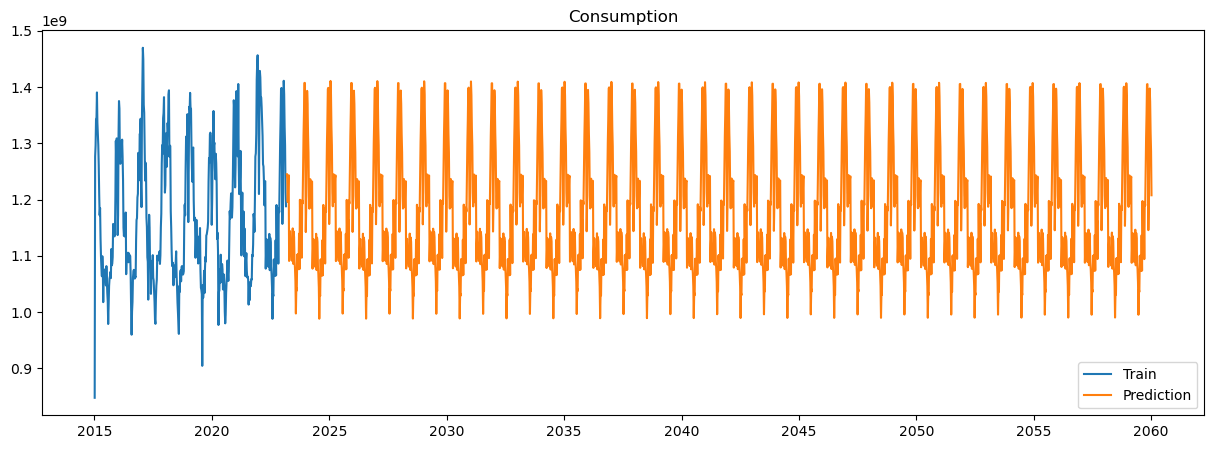

In [72]:
# Use the model to predict the next 3 years
model = SARIMAX(cons[:-1]['Consumption'], order=(1, 0, 0), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit()
cons_predictions = model_fit.predict(start=len(cons), end=len(cons_full)-1, dynamic=False)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(cons[:-1]['Date'], cons[:-1]['Consumption'], label='Train')
plt.plot(cons_pred['Date'], cons_predictions, label='Prediction')
plt.legend(loc='best')
plt.title('Consumption')
plt.show()

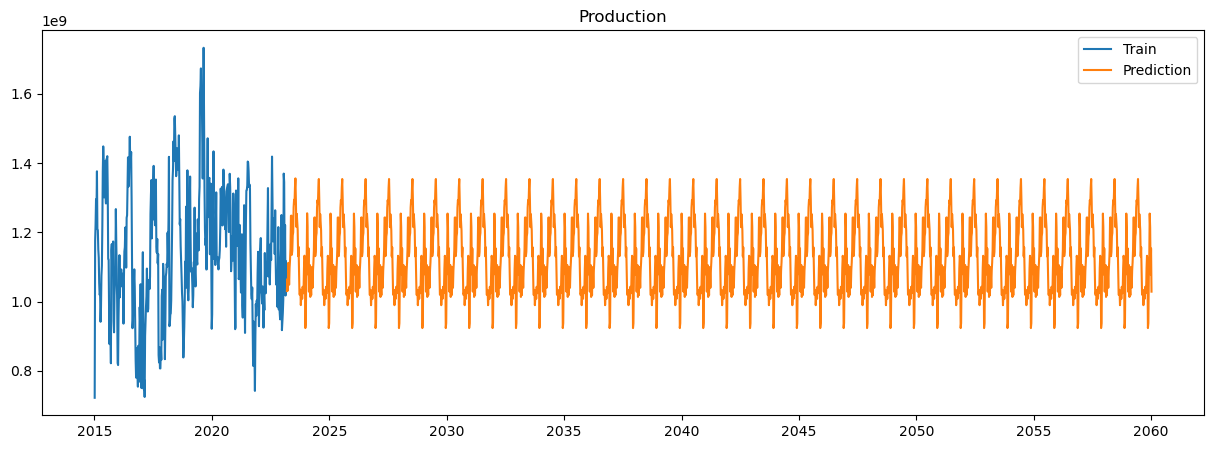

In [73]:
# Use the model to predict the next 3 years
model = SARIMAX(prod[:-1]['Production'], order=(1, 0, 0), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit()
prod_predictions = model_fit.predict(start=len(prod), end=len(prod_full)-1, dynamic=False)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(prod[:-1]['Date'], prod[:-1]['Production'], label='Train')
plt.plot(prod_pred['Date'], prod_predictions, label='Prediction')
plt.legend(loc='best')
plt.title('Production')
plt.show()

In [74]:
# Add the predictions to the dataframe
prod_pred['Production'] = prod_predictions
cons_pred['Consumption'] = cons_predictions

C:\Users\thozi\AppData\Local\Temp\ipykernel_22028\3762068851.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\thozi\AppData\Local\Temp\ipykernel_22028\3762068851.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
df_CHpred = pd.read_csv('../../Data/CHpred.csv', sep=';')
# 'Year' contains the date in the format 'YYYY' so we need to convert it to a datetime format
df_CHpred['Date'] = pd.to_datetime(df_CHpred['Year'], format='%Y')
# Set the 'Date' column as the index
df_CHpred.set_index('Date', inplace=True)
# Drop the 'Year' column
df_CHpred.drop('Year', axis=1, inplace=True)


# Keep only the years later than 2015
df_CHpred = df_CHpred[df_CHpred.index > '2015-01-01']

# Multiply the values by 1 000 000 000
df_CHpred['Production'] = df_CHpred['Prod'] * 1000000000
df_CHpred['Consumption'] = df_CHpred['Cons'] * 1000000000

# Drop the 'Prod' column
df_CHpred.drop('Prod', axis=1, inplace=True)
# Drop the 'Cons' column
df_CHpred.drop('Cons', axis=1, inplace=True)

df_CHpred.head()

,Production,Consumption
Date,,
2016-01-01,5.870000e+10,6.550000e+10
2017-01-01,5.730000e+10,6.700000e+10
2018-01-01,6.360000e+10,6.600000e+10
2019-01-01,6.780000e+10,6.560000e+10
2020-01-01,6.240000e+10,6.680000e+10


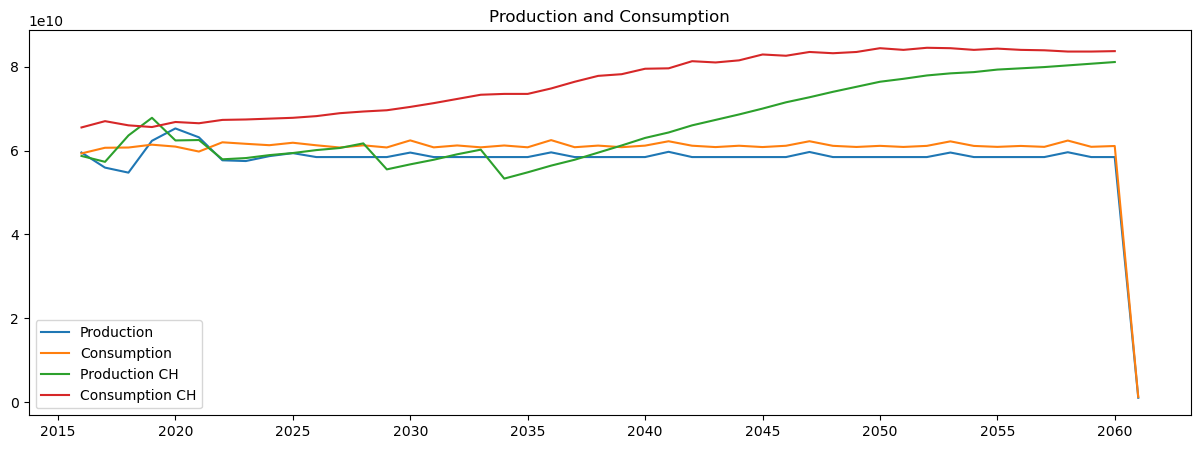

In [110]:
# Merge the two dataframes into one and add a column that says if it's prediction or not
prod_pred['Prediction'] = 1
cons_pred['Prediction'] = 1
prod['Prediction'] = 0
cons['Prediction'] = 0

prod_full = pd.concat([prod, prod_pred])
cons_full = pd.concat([cons, cons_pred])

# If a value is under 0.5B, we set it to 0
prod_full.loc[prod_full['Production'] < 500000000, 'Production'] = 0
cons_full.loc[cons_full['Consumption'] < 500000000, 'Consumption'] = 0

# Interpolate values that are 0
prod_full['Production'] = prod_full['Production'].replace(0, np.nan).interpolate()
cons_full['Consumption'] = cons_full['Consumption'].replace(0, np.nan).interpolate()

# Create 2 new dataframes with the sum of production and consumption per year
prod_full_year = prod_full.groupby(pd.Grouper(key='Date', freq='Y')).sum()
cons_full_year = cons_full.groupby(pd.Grouper(key='Date', freq='Y')).sum()


# Plot the results, alonside df_CHpred
plt.figure(figsize=(15, 5))
plt.plot(prod_full_year['Production'], label='Production')
plt.plot(cons_full_year['Consumption'], label='Consumption')
plt.plot(df_CHpred['Production'], label='Production CH')
plt.plot(df_CHpred['Consumption'], label='Consumption CH')
plt.legend(loc='best')
plt.title('Production and Consumption')
plt.show()



# Plot the results using plolty
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=prod_full['Date'], y=prod_full['Production'], name='Production'))
fig.add_trace(go.Scatter(x=cons_full['Date'], y=cons_full['Consumption'], name='Consumption'))
fig.update_layout(title='Production and Consumption', xaxis_title='Date', yaxis_title='Production and Consumption')
fig.show()

In [112]:
prod_full_year.to_csv('../../Data/prod_yearly_PI.csv', sep=';')
cons_full_year.to_csv('../../Data/cons_yearly_PI.csv', sep=';')

prod_full.to_csv('../../Data/prod_PI.csv', sep=';')
cons_full.to_csv('../../Data/cons_PI.csv', sep=';')

df_CHpred.to_csv('../../Data/CHpred_CH.csv', sep=';')

,Production PI,Prediction,Consumption PI,Prediction,Production CH,Consumption CH
Date,,,,,,
2015-12-31,5.952820e+10,0.0,5.930132e+10,0.0,NaN,NaN
2016-01-01,NaN,NaN,NaN,NaN,5.870000e+10,6.550000e+10
2016-12-31,5.592400e+10,0.0,6.065347e+10,0.0,NaN,NaN
2017-01-01,NaN,NaN,NaN,NaN,5.730000e+10,6.700000e+10
2017-12-31,5.472276e+10,0.0,6.071253e+10,0.0,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN,6.360000e+10,6.600000e+10
2018-12-31,6.231208e+10,0.0,6.138888e+10,0.0,NaN,NaN
2019-01-01,NaN,NaN,NaN,NaN,6.780000e+10,6.560000e+10
2019-12-31,6.526278e+10,0.0,6.093567e+10,0.0,NaN,NaN
